In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Wed Jun 26 15:19:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:04:00.0 Off |                  Off |
| N/A   33C    P0    49W / 250W |    473MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:0D:00.0 Off |                  Off |
| N/A   36C    P0    50W / 250W |  23748MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "6"
warnings.simplefilter('ignore')

In [4]:
computation_kwargs = {'cuda_visible_devices': 0}

In [11]:
sys.path = sys.path[1:]
sys.path.append(os.path.abspath(os.pardir))
#sys.path.append(os.path.join(os.path.abspath(os.pardir), 'odometry'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tfoptflow/tfoptflow'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tf_models/research/struct2depth'))

In [6]:
optical_flow_checkpoint = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'
#optical_flow_checkpoint ='/Vol0/user/f.konokhov/tfoptflow/tfoptflow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000' # official weights
print('optical flow', optical_flow_checkpoint)

depth_checkpoint = os.path.abspath('../weights/model-199160')
print('depth', depth_checkpoint)

optical flow /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000
depth /Vol0/user/f.konokhov/odometry3/odometry/weights/model-199160


In [7]:
dataframe = pd.read_csv('/dbstore/datasets/Odometry_team/discoman_v10_full/000197/df.csv', index_col=0)
#dataframe = pd.read_csv('meetingroom_04_rgbd_ir_imu_pose_KITTI_finetuned/df.csv', index_col=0)
dataframe.head()

,timestamp,path_to_depth,path_to_rgb,timestamp_next,path_to_depth_next,path_to_rgb_next,euler_x,euler_y,euler_z,t_x,t_y,t_z,path_to_optical_flow
0,0,depth/0.png,rgb/0.jpg,5,depth/1.png,rgb/1.jpg,0.000096,-0.000417,-0.000003,0.000047,0.000005,0.000180,optical_flow/0_1.npy
1,5,depth/1.png,rgb/1.jpg,10,depth/2.png,rgb/2.jpg,0.000376,-0.002086,0.000049,0.000195,0.000018,0.000649,optical_flow/1_2.npy
2,10,depth/2.png,rgb/2.jpg,15,depth/3.png,rgb/3.jpg,0.000645,-0.003824,0.000159,0.000348,0.000028,0.001168,optical_flow/2_3.npy
3,15,depth/3.png,rgb/3.jpg,20,depth/4.png,rgb/4.jpg,0.000972,-0.005562,0.000272,0.000552,0.000034,0.001644,optical_flow/3_4.npy
4,20,depth/4.png,rgb/4.jpg,25,depth/5.png,rgb/5.jpg,0.001178,-0.007303,0.000205,0.000581,0.000064,0.002070,optical_flow/4_5.npy


In [8]:
dataframe = dataframe[['t_x', 't_y', 't_z', 'euler_x', 'euler_y', 'euler_z', 'path_to_rgb']]
dataframe.path_to_rgb = dataframe.path_to_rgb.apply(
    lambda x: os.path.join('/dbstore/datasets/Odometry_team/discoman_v10_full/000197/', x))
dataframe.head()

,t_x,t_y,t_z,euler_x,euler_y,euler_z,path_to_rgb
0,0.000047,0.000005,0.000180,0.000096,-0.000417,-0.000003,/dbstore/datasets/Odometry_team/discoman_v10_f...
1,0.000195,0.000018,0.000649,0.000376,-0.002086,0.000049,/dbstore/datasets/Odometry_team/discoman_v10_f...
2,0.000348,0.000028,0.001168,0.000645,-0.003824,0.000159,/dbstore/datasets/Odometry_team/discoman_v10_f...
3,0.000552,0.000034,0.001644,0.000972,-0.005562,0.000272,/dbstore/datasets/Odometry_team/discoman_v10_f...
4,0.000581,0.000064,0.002070,0.001178,-0.007303,0.000205,/dbstore/datasets/Odometry_team/discoman_v10_f...


In [9]:
dataset_root = 'test_estimators'

height = 480
width = 640

#height = 94
#width = 300

In [12]:
from odometry.preprocessing.estimators.pwcnet_feature_extractor import PWCNetFeatureExtractor

In [13]:
pwcnet_Extractor = PWCNetFeatureExtractor(input_col=['path_to_rgb', 'path_to_rgb'],
                                   output_col='path_to_optical_flow',
                                   sub_dir='optical_flow',
                                   checkpoint=optical_flow_checkpoint,
                                   height=height,
                                   width=width)
pwcnet_Extractor

Building model...
... model built.
Loading model checkpoint /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000 for eval or testing...

INFO:tensorflow:Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


I0626 15:21:19.855899 46999044660864 tf_logging.py:115] Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


... model loaded


PWCNetExtractorEstimator(dir=optical_flow, input_col=['path_to_rgb', 'path_to_rgb'], output_col=path_to_optical_flow, checkpoint=/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000)

In [14]:
dataframe = dataframe[:-1].join(dataframe[1:].copy().reset_index(), rsuffix='_next')
dataframe.drop('index', axis=1, inplace=True)
dataframe.head()

,t_x,t_y,t_z,euler_x,euler_y,euler_z,path_to_rgb,t_x_next,t_y_next,t_z_next,euler_x_next,euler_y_next,euler_z_next,path_to_rgb_next
0,0.000047,0.000005,0.000180,0.000096,-0.000417,-0.000003,/dbstore/datasets/Odometry_team/discoman_v10_f...,0.000195,0.000018,0.000649,0.000376,-0.002086,0.000049,/dbstore/datasets/Odometry_team/discoman_v10_f...
1,0.000195,0.000018,0.000649,0.000376,-0.002086,0.000049,/dbstore/datasets/Odometry_team/discoman_v10_f...,0.000348,0.000028,0.001168,0.000645,-0.003824,0.000159,/dbstore/datasets/Odometry_team/discoman_v10_f...
2,0.000348,0.000028,0.001168,0.000645,-0.003824,0.000159,/dbstore/datasets/Odometry_team/discoman_v10_f...,0.000552,0.000034,0.001644,0.000972,-0.005562,0.000272,/dbstore/datasets/Odometry_team/discoman_v10_f...
3,0.000552,0.000034,0.001644,0.000972,-0.005562,0.000272,/dbstore/datasets/Odometry_team/discoman_v10_f...,0.000581,0.000064,0.002070,0.001178,-0.007303,0.000205,/dbstore/datasets/Odometry_team/discoman_v10_f...
4,0.000581,0.000064,0.002070,0.001178,-0.007303,0.000205,/dbstore/datasets/Odometry_team/discoman_v10_f...,0.000372,0.000123,0.002433,0.001181,-0.009052,-0.000077,/dbstore/datasets/Odometry_team/discoman_v10_f...


In [40]:
pwcnet_Extractor = PWCNetFeatureExtractor(input_col=['path_to_rgb', 'path_to_rgb_next'],
                                   output_col='path_to_optical_flow',
                                   sub_dir='optical_flow',
                                   checkpoint=optical_flow_checkpoint,
                                   height=height,
                                   width=width)
pwcnet_Extractor

Building model...
... model built.
Loading model checkpoint /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000 for eval or testing...

INFO:tensorflow:Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


I0624 14:01:43.613977 47947784224384 tf_logging.py:115] Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


... model loaded


PWCNetExtractorEstimator(dir=optical_flow, input_col=['path_to_rgb', 'path_to_rgb_next'], output_col=path_to_optical_flow, checkpoint=/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000)

In [16]:
row = []

In [17]:
index, row = next(dataframe.iterrows())
row

t_x                                                       4.66722e-05
t_y                                                       4.64376e-06
t_z                                                       0.000179775
euler_x                                                   9.56835e-05
euler_y                                                  -0.000416883
euler_z                                                  -3.21506e-06
path_to_rgb         /dbstore/datasets/Odometry_team/discoman_v10_f...
t_x_next                                                  0.000195366
t_y_next                                                  1.76489e-05
t_z_next                                                  0.000649189
euler_x_next                                              0.000375979
euler_y_next                                              -0.00208619
euler_z_next                                              4.85222e-05
path_to_rgb_next    /dbstore/datasets/Odometry_team/discoman_v10_f...
Name: 0, dtype: obje

In [18]:
row.path_to_rgb = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/samples/mpisintel_test_clean_ambush_1_frame_0001.png'

In [19]:
row.path_to_rgb_next = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/samples/mpisintel_test_clean_ambush_1_frame_0002.png'

In [20]:
row = pwcnet_Extractor._load_model_input(row, dataset_root)

In [41]:
feature_flow = pwcnet_Extractor._run_model_inference(row)

In [42]:
feature_flow[1][0].shape

(1, 224, 512, 16)

In [43]:
len(feature_flow[1])

6

In [44]:
feature_flow[1][5].shape

(1, 7, 16, 196)

In [57]:
for i in range(128):
    print('max:', feature_flow[1][5][0,:,:,i].max(),'min:', feature_flow[1][5][0,:,:,i].min())

max: -1.6269912e-32 min: -1.6269912e-32
max: -9.586589e-34 min: -9.586589e-34
max: 7.444474e-32 min: 7.444474e-32
max: 7.449553e-33 min: 7.449553e-33
max: 8.832073e-32 min: 8.832073e-32
max: -7.5045205e-33 min: -7.5045205e-33
max: -1.5874577e-32 min: -1.5874577e-32
max: -1.6409039e-32 min: -1.6409039e-32
max: 1.9775125e-32 min: 1.9775125e-32
max: -4.494182e-33 min: -4.494182e-33
max: 1.7063376e-31 min: 1.7063376e-31
max: 8.993933e-32 min: 8.993933e-32
max: -2.3299237e-32 min: -2.3299237e-32
max: -3.423732e-33 min: -3.423732e-33
max: 2.5972692e-32 min: 2.5972692e-32
max: 1.3290977e-33 min: 1.3290977e-33
max: -2.3445986e-32 min: -2.3445986e-32
max: -2.0935576e-32 min: -2.0935576e-32
max: -1.4592915e-32 min: -1.4592915e-32
max: -1.9665864e-33 min: -1.9665864e-33
max: -1.8247976e-32 min: -1.8247976e-32
max: -1.4720003e-32 min: -1.4720003e-32
max: -2.368545e-32 min: -2.368545e-32
max: -2.2465965e-33 min: -2.2465965e-33
max: -2.7790767e-32 min: -2.7790767e-32
max: 2.1552881e-32 min: 2.155288

In [46]:
%matplotlib inline

In [47]:
import matplotlib.pyplot as plt

In [48]:
feature_flow[1][5][0,:,:,:].max()

1.974226e-31

In [49]:
feature_flow[1][5][0,:,:,0].max()

-1.6269912e-32

In [50]:
feature_flow[1][5][0,:,:,0].min()

-1.6269912e-32

In [51]:
feature_flow[0].shape

(1, 448, 1024, 2)

In [52]:
feature_flow[0][0,...,0].mean()

-44.36532

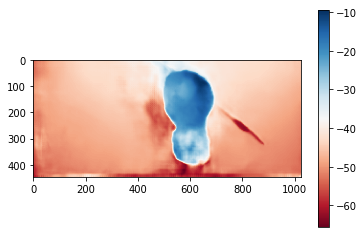

In [53]:
plt.imshow(feature_flow[0][0,...,0], cmap= 'RdBu')
plt.colorbar()
plt.show()


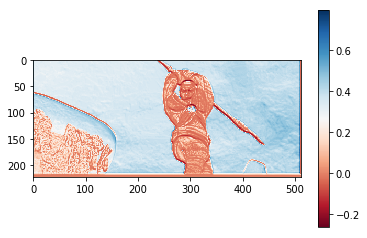

In [54]:
plt.imshow(feature_flow[1][0][0,:,:,10], cmap= 'RdBu')
plt.colorbar()

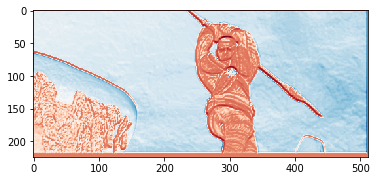

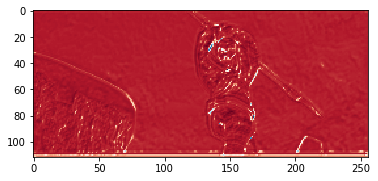

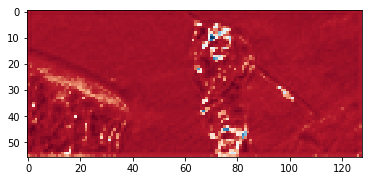

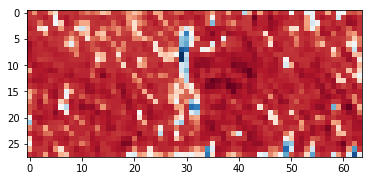

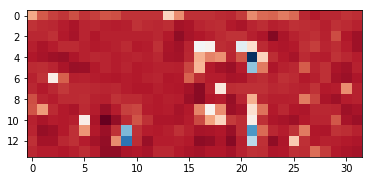

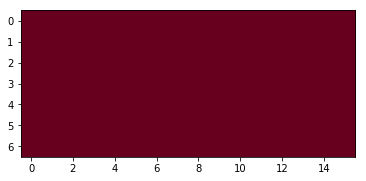

In [55]:
for i in range(6):
    plt.imshow(feature_flow[1][i][0,:,:,10], cmap= 'RdBu')
    plt.show()